This IPython Notebook illustrates the use of the `openmc.mgxs` module to calculate multi-group cross sections for a heterogeneous fuel pin cell geometry. In particular, this Notebook illustrates the following features:

* Creation of multi-group cross sections on a **heterogeneous geometry**
* Calculation of cross sections on a **nuclide-by-nuclide basis**
* The use of **[tally precision triggers](https://mit-crpg.github.io/openmc/usersguide/input.html#trigger-element)** with multi-group cross sections
* Built-in features for **energy condensation** in downstream data processing
* The use of **[PyNE](http://pyne.io/) to plot** continuous-energy vs. multi-group cross sections
* **Validation** of multi-group cross sections with **[OpenMOC](https://mit-crpg.github.io/OpenMOC/)**

**Note:** This Notebook was created using [OpenMOC](https://mit-crpg.github.io/OpenMOC/) to verify the multi-group cross-sections generated by OpenMC. In order to run this Notebook in its entirety, you must have [OpenMOC](https://mit-crpg.github.io/OpenMOC/) installed on your system, along with OpenCG to convert the OpenMC geometries into OpenMOC geometries. In addition, this Notebook illustrates the use of [Pandas](http://pandas.pydata.org/) `DataFrames` to containerize multi-group cross section data.

## Generate Input Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import openmc
import openmc.mgxs as mgxs
import openmoc
from openmoc.opencg_compatible import get_openmoc_geometry
import pyne.ace

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.1+1178.ga40c9ec-py2.7-linux-x86_64.egg/matplotlib/__init__.py:884: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.1+1178.ga40c9ec-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1362: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: QAWarning: pyne.rxname is not yet QA compliant.
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: QAWarning: pyne.ace is not yet QA compliant.


First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H-1')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')
zr90 = openmc.Nuclide('Zr-90')

With the nuclides we defined, we will now create three distinct materials for water, clad and fuel.

In [3]:
# 1.6% enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our materials, we can now create a `Materials` object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. Our problem will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces -- in this case two cylinders and six reflective planes.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

With the surfaces defined, we can now create cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [7]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.region = +min_x & -max_x & +min_y & -max_y
root_cell.fill = pin_cell_universe

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [8]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry()
openmc_geometry.root_universe = root_universe

# Export to "geometry.xml"
openmc_geometry.export_to_xml()

Next, we must define simulation parameters. In this case, we will use 10 inactive batches and 190 active batches each with 10,000 particles.

In [9]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 10000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Activate tally precision triggers
settings_file.trigger_active = True
settings_file.trigger_max_batches = settings_file.batches * 4

# Export to "settings.xml"
settings_file.export_to_xml()

Now we are finally ready to make use of the `openmc.mgxs` module to generate multi-group cross sections! First, let's define "coarse" 2-group and "fine" 8-group structures using the built-in `EnergyGroups` class.

In [10]:
# Instantiate a "coarse" 2-group EnergyGroups object
coarse_groups = mgxs.EnergyGroups()
coarse_groups.group_edges = np.array([0., 0.625e-6, 20.])

# Instantiate a "fine" 8-group EnergyGroups object
fine_groups = mgxs.EnergyGroups()
fine_groups.group_edges = np.array([0., 0.058e-6, 0.14e-6, 0.28e-6,
                                    0.625e-6, 4.e-6, 5.53e-3, 821.e-3, 20.])

Now we will instantiate a variety of `MGXS` objects needed to run an OpenMOC simulation to verify the accuracy of our cross sections. In particular, we define transport, fission, nu-fission, nu-scatter and chi cross sections for each of the three cells in the fuel pin with the 8-group structure as our energy groups.

In [11]:
# Extract all Cells filled by Materials
openmc_cells = openmc_geometry.get_all_material_cells()

# Create dictionary to store multi-group cross sections for all cells
xs_library = {}

# Instantiate 8-group cross sections for each cell
for cell in openmc_cells:
    xs_library[cell.id] = {}
    xs_library[cell.id]['transport']  = mgxs.TransportXS(groups=fine_groups)
    xs_library[cell.id]['fission'] = mgxs.FissionXS(groups=fine_groups)
    xs_library[cell.id]['nu-fission'] = mgxs.NuFissionXS(groups=fine_groups)
    xs_library[cell.id]['nu-scatter'] = mgxs.NuScatterMatrixXS(groups=fine_groups)
    xs_library[cell.id]['chi'] = mgxs.Chi(groups=fine_groups)

Next, we showcase the use of OpenMC's [tally precision trigger](https://mit-crpg.github.io/openmc/usersguide/input.html#trigger-element) feature in conjunction with the `openmc.mgxs` module. In particular, we will assign a tally trigger of 1E-2 on the standard deviation for each of the tallies used to compute multi-group cross sections.

In [12]:
# Create a tally trigger for +/- 0.01 on each tally used to compute the multi-group cross sections
tally_trigger = openmc.Trigger('std_dev', 1E-2)

# Add the tally trigger to each of the multi-group cross section tallies
for cell in openmc_cells:
    for mgxs_type in xs_library[cell.id]:
        xs_library[cell.id][mgxs_type].tally_trigger = tally_trigger

Now, we must loop over all cells to set the cross section domains to the various cells - fuel, clad and moderator - included in the geometry. In addition, we will set each cross section to tally cross sections on a per-nuclide basis through the use of the `MGXS` class' boolean `by_nuclide` instance attribute.  

In [13]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id]:

        # Set the cross sections domain to the cell
        xs_library[cell.id][rxn_type].domain = cell
        
        # Tally cross sections by nuclide
        xs_library[cell.id][rxn_type].by_nuclide = True
                
        # Add OpenMC tallies to the tallies file for XML generation
        for tally in xs_library[cell.id][rxn_type].tallies.values():
            tallies_file.append(tally, merge=True)

# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [14]:
# Run OpenMC
openmc.run(output=True)


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2016 Massachusetts Institute of Technology
      License:        http://openmc.readthedocs.io/en/latest/license.html
      Version:        0.7.1
      Git SHA1:       19feb55e6d5e8350398627f39fb55ee8e2e63011
      Date/Time:      2016-05-13 10:13:48
      MPI Processes:  1

 =================

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [15]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.074.h5')

The statepoint is now ready to be analyzed by our multi-group cross sections. We simply have to load the tallies from the `StatePoint` into each object as follows and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [16]:
# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id]:
        xs_library[cell.id][rxn_type].load_from_statepoint(sp)

That's it! Our multi-group cross sections are now ready for the big spotlight. This time we have cross sections in three distinct spatial zones - fuel, clad and moderator - on a per-nuclide basis.

## Extracting and Storing MGXS Data

Let's first inspect one of our cross sections by printing it to the screen as a microscopic cross section in units of barns.

In [17]:
nufission = xs_library[fuel_cell.id]['nu-fission']
nufission.print_xs(xs_type='micro', nuclides=['U-235', 'U-238'])

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	10000
	Nuclide        =	U-235
	Cross Sections [barns]:
            Group 1 [0.821      - 20.0      MeV]:	3.30e+00 +/- 2.19e-01%
            Group 2 [0.00553    - 0.821     MeV]:	3.96e+00 +/- 1.32e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	5.52e+01 +/- 2.31e-01%
            Group 4 [6.25e-07   - 4e-06     MeV]:	8.83e+01 +/- 2.96e-01%
            Group 5 [2.8e-07    - 6.25e-07  MeV]:	2.90e+02 +/- 4.64e-01%
            Group 6 [1.4e-07    - 2.8e-07   MeV]:	4.49e+02 +/- 4.22e-01%
            Group 7 [5.8e-08    - 1.4e-07   MeV]:	6.87e+02 +/- 2.97e-01%
            Group 8 [0.0        - 5.8e-08   MeV]:	1.44e+03 +/- 2.91e-01%

	Nuclide        =	U-238
	Cross Sections [barns]:
            Group 1 [0.821      - 20.0      MeV]:	1.06e+00 +/- 2.56e-01%
            Group 2 [0.00553    - 0.821     MeV]:	1.21e-03 +/- 2.55e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	5.77e-04 +/- 3.67e+00%
       

Our multi-group cross sections are capable of summing across all nuclides to provide us with macroscopic cross sections as well.

In [18]:
nufission = xs_library[fuel_cell.id]['nu-fission']
nufission.print_xs(xs_type='macro', nuclides='sum')

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	10000
	Cross Sections [cm^-1]:
            Group 1 [0.821      - 20.0      MeV]:	2.52e-02 +/- 2.44e-01%
            Group 2 [0.00553    - 0.821     MeV]:	1.51e-03 +/- 1.30e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	2.07e-02 +/- 2.31e-01%
            Group 4 [6.25e-07   - 4e-06     MeV]:	3.31e-02 +/- 2.96e-01%
            Group 5 [2.8e-07    - 6.25e-07  MeV]:	1.09e-01 +/- 4.64e-01%
            Group 6 [1.4e-07    - 2.8e-07   MeV]:	1.69e-01 +/- 4.22e-01%
            Group 7 [5.8e-08    - 1.4e-07   MeV]:	2.58e-01 +/- 2.97e-01%
            Group 8 [0.0        - 5.8e-08   MeV]:	5.40e-01 +/- 2.91e-01%





Although a printed report is nice, it is not scalable or flexible. Let's extract the microscopic cross section data for the moderator as a [Pandas](http://pandas.pydata.org/) `DataFrame` .

In [19]:
nuscatter = xs_library[moderator_cell.id]['nu-scatter']
df = nuscatter.get_pandas_dataframe(xs_type='micro')
df.head(10)

,cell,group in,group out,nuclide,mean,std. dev.
126,10002,1,1,H-1,0.234115,0.003568
127,10002,1,1,O-16,1.563707,0.005953
124,10002,1,2,H-1,1.594129,0.002369
125,10002,1,2,O-16,0.285761,0.001676
122,10002,1,3,H-1,0.011089,0.000248
123,10002,1,3,O-16,0.000000,0.000000
120,10002,1,4,H-1,0.000000,0.000000
121,10002,1,4,O-16,0.000000,0.000000
118,10002,1,5,H-1,0.000000,0.000000
119,10002,1,5,O-16,0.000000,0.000000


Next, we illustate how one can easily take multi-group cross sections and condense them down to a coarser energy group structure. The `MGXS` class includes a `get_condensed_xs(...)` method which takes an `EnergyGroups` parameter with a coarse(r) group structure and returns a new `MGXS` condensed to the coarse groups. We illustrate this process below using the 2-group structure created earlier.

In [20]:
# Extract the 16-group transport cross section for the fuel
fine_xs = xs_library[fuel_cell.id]['transport']

# Condense to the 2-group structure
condensed_xs = fine_xs.get_condensed_xs(coarse_groups)

Group condensation is as simple as that! We now have a new coarse 2-group `TransportXS` in addition to our original 16-group `TransportXS`. Let's inspect the 2-group `TransportXS` by printing it to the screen and extracting a Pandas `DataFrame` as we have already learned how to do.

In [21]:
condensed_xs.print_xs()

Multi-Group XS
	Reaction Type  =	transport
	Domain Type    =	cell
	Domain ID      =	10000
	Nuclide        =	U-235
	Cross Sections [cm^-1]:
            Group 1 [6.25e-07   - 20.0      MeV]:	7.73e-03 +/- 5.06e-01%
            Group 2 [0.0        - 6.25e-07  MeV]:	1.82e-01 +/- 2.05e-01%

	Nuclide        =	U-238
	Cross Sections [cm^-1]:
            Group 1 [6.25e-07   - 20.0      MeV]:	2.17e-01 +/- 1.44e-01%
            Group 2 [0.0        - 6.25e-07  MeV]:	2.53e-01 +/- 2.57e-01%

	Nuclide        =	O-16
	Cross Sections [cm^-1]:
            Group 1 [6.25e-07   - 20.0      MeV]:	1.46e-01 +/- 1.60e-01%
            Group 2 [0.0        - 6.25e-07  MeV]:	1.75e-01 +/- 2.94e-01%





In [22]:
df = condensed_xs.get_pandas_dataframe(xs_type='micro')
df

,cell,group in,nuclide,mean,std. dev.
3,10000,1,U-235,20.611692,0.104237
4,10000,1,U-238,9.585358,0.013808
5,10000,1,O-16,3.164190,0.005049
0,10000,2,U-235,485.413426,0.996410
1,10000,2,U-238,11.190386,0.028731
2,10000,2,O-16,3.794859,0.011139


## Verification with OpenMOC

Now, let's verify our cross sections using OpenMOC. First, we use OpenCG construct an equivalent OpenMOC geometry.

In [23]:
# Create an OpenMOC Geometry from the OpenCG Geometry
openmoc_geometry = get_openmoc_geometry(sp.summary.opencg_geometry)

Next, we we can inject the multi-group cross sections into the equivalent fuel pin cell OpenMOC geometry.

In [24]:
# Get all OpenMOC cells in the gometry
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
for cell_id, cell in openmoc_cells.items():
    
    # Ignore the root cell
    if cell.getName() == 'root cell':
        continue
    
    # Get a reference to the Material filling this Cell
    openmoc_material = cell.getFillMaterial()
    
    # Set the number of energy groups for the Material
    openmoc_material.setNumEnergyGroups(fine_groups.num_groups)
    
    # Extract the appropriate cross section objects for this cell
    transport = xs_library[cell_id]['transport']
    nufission = xs_library[cell_id]['nu-fission']
    nuscatter = xs_library[cell_id]['nu-scatter']
    chi = xs_library[cell_id]['chi']
    
    # Inject NumPy arrays of cross section data into the Material
    # NOTE: Sum across nuclides to get macro cross sections needed by OpenMOC
    openmoc_material.setSigmaT(transport.get_xs(nuclides='sum').flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs(nuclides='sum').flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs(nuclides='sum').flatten())
    openmoc_material.setChi(chi.get_xs(nuclides='sum').flatten())

We are now ready to run OpenMOC to verify our cross-sections from OpenMC.

In [25]:
# Generate tracks for OpenMOC
track_generator = openmoc.TrackGenerator(openmoc_geometry, num_azim=128, azim_spacing=0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Importing ray tracing data from file...
[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 0.574672	res = 0.000E+00
[  NORMAL ]  Iteration 1:	k_eff = 0.679815	res = 4.253E-01
[  NORMAL ]  Iteration 2:	k_eff = 0.660826	res = 1.830E-01
[  NORMAL ]  Iteration 3:	k_eff = 0.658940	res = 2.793E-02
[  NORMAL ]  Iteration 4:	k_eff = 0.643012	res = 2.853E-03
[  NORMAL ]  Iteration 5:	k_eff = 0.625810	res = 2.417E-02
[  NORMAL ]  Iteration 6:	k_eff = 0.606678	res = 2.675E-02
[  NORMAL ]  Iteration 7:	k_eff = 0.587485	res = 3.057E-02
[  NORMAL ]  Iteration 8:	k_eff = 0.569028	res = 3.164E-02
[  NORMAL ]  Iteration 9:	k_eff = 0.551707	res = 3.142E-02
[  NORMAL ]  Iteration 10:	k_eff = 0.536034	res = 3.044E-02
[  NORMAL ]  Iteration 11:	k_eff = 0.522274	res = 2.841E-02
[  NORMAL ]  Iteration 12:	k_eff = 0.510609	res = 2.567E-02
[  NORMAL ]  Iteration 13:	k_eff = 0.501105	res = 2.234E-02
[  NORMAL ]  Iteration 14:	k_eff = 0.493831	res = 1.861E-02
[  NORMAL ]  Ite

We report the eigenvalues computed by OpenMC and OpenMOC here together to summarize our results.

In [26]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined[0]
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.223474
openmoc keff = 1.220892
bias [pcm]: -258.1


As a sanity check, let's run a simulation with the coarse 2-group cross sections to ensure that they also produce a reasonable result.

In [27]:
openmoc_geometry = get_openmoc_geometry(sp.summary.opencg_geometry)
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
for cell_id, cell in openmoc_cells.items():
    
    # Ignore the root cell
    if cell.getName() == 'root cell':
        continue
    
    openmoc_material = cell.getFillMaterial()
    openmoc_material.setNumEnergyGroups(coarse_groups.num_groups)
    
    # Extract the appropriate cross section objects for this cell
    transport = xs_library[cell_id]['transport']
    nufission = xs_library[cell_id]['nu-fission']
    nuscatter = xs_library[cell_id]['nu-scatter']
    chi = xs_library[cell_id]['chi']
    
    # Perform group condensation
    transport = transport.get_condensed_xs(coarse_groups)
    nufission = nufission.get_condensed_xs(coarse_groups)
    nuscatter = nuscatter.get_condensed_xs(coarse_groups)
    chi = chi.get_condensed_xs(coarse_groups)
    
    # Inject NumPy arrays of cross section data into the Material
    openmoc_material.setSigmaT(transport.get_xs(nuclides='sum').flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs(nuclides='sum').flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs(nuclides='sum').flatten())
    openmoc_material.setChi(chi.get_xs(nuclides='sum').flatten())

In [28]:
# Generate tracks for OpenMOC
track_generator = openmoc.TrackGenerator(openmoc_geometry, num_azim=128, azim_spacing=0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Importing ray tracing data from file...
[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 0.495816	res = 0.000E+00
[  NORMAL ]  Iteration 1:	k_eff = 0.557477	res = 5.042E-01
[  NORMAL ]  Iteration 2:	k_eff = 0.518300	res = 1.244E-01
[  NORMAL ]  Iteration 3:	k_eff = 0.509211	res = 7.027E-02
[  NORMAL ]  Iteration 4:	k_eff = 0.496489	res = 1.754E-02
[  NORMAL ]  Iteration 5:	k_eff = 0.488581	res = 2.498E-02
[  NORMAL ]  Iteration 6:	k_eff = 0.482897	res = 1.593E-02
[  NORMAL ]  Iteration 7:	k_eff = 0.479775	res = 1.163E-02
[  NORMAL ]  Iteration 8:	k_eff = 0.478834	res = 6.465E-03
[  NORMAL ]  Iteration 9:	k_eff = 0.479871	res = 1.960E-03
[  NORMAL ]  Iteration 10:	k_eff = 0.482684	res = 2.166E-03
[  NORMAL ]  Iteration 11:	k_eff = 0.487084	res = 5.861E-03
[  NORMAL ]  Iteration 12:	k_eff = 0.492900	res = 9.116E-03
[  NORMAL ]  Iteration 13:	k_eff = 0.499971	res = 1.194E-02
[  NORMAL ]  Iteration 14:	k_eff = 0.508153	res = 1.435E-02
[  NORMAL ]  Ite

In [29]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined[0]
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.223474
openmoc keff = 1.223227
bias [pcm]: -24.7


There is a non-trivial bias in both the 2-group and 8-group cases. In the case of a pin cell, one can show that these biases do not converge to <100 pcm with more particle histories. For heterogeneous geometries, additional measures must be taken to address the following three sources of bias:

* Appropriate transport-corrected cross sections
* Spatial discretization of OpenMOC's mesh
* Constant-in-angle multi-group cross sections

## Visualizing MGXS Data

It is often insightful to generate visual depictions of multi-group cross sections. There are many different types of plots which may be useful for multi-group cross section visualization, only a few of which will be shown here for enrichment and inspiration.

One particularly useful visualization is a comparison of the continuous-energy and multi-group cross sections for a particular nuclide and reaction type. We illustrate one option for generating such plots with the use of the open source [PyNE](http://pyne.io/) library to parse continuous-energy cross sections from the cross section data library provided with OpenMC. First, we instantiate a `pyne.ace.Library` object for U-235 as follows.

In [30]:
# Instantiate a PyNE ACE continuous-energy cross sections library
pyne_lib = pyne.ace.Library('../../../../data/nndc/293.6K/U_235_293.6K.ace')
pyne_lib.read('92235.71c')

# Extract the U-235 data from the library
u235 = pyne_lib.tables['92235.71c']

# Extract the continuous-energy U-235 fission cross section data
fission = u235.reactions[18]

Now, we use [`matplotlib`](http://matplotlib.org/) and [`seaborn`](http://stanford.edu/~mwaskom/software/seaborn/) to plot the continuous-energy and multi-group cross sections on a single plot.

(9.9999999999999994e-12, 20.0)

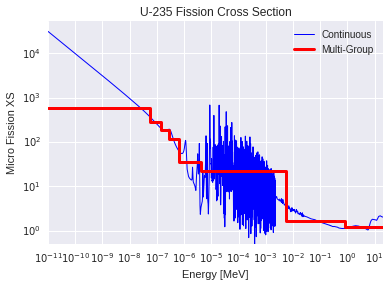

In [31]:
# Create a loglog plot of the U-235 continuous-energy fission cross section 
plt.loglog(u235.energy, fission.sigma, color='b', linewidth=1)

# Extract energy group bounds and MGXS values to plot
nufission = xs_library[fuel_cell.id]['fission']
energy_groups = nufission.energy_groups
x = energy_groups.group_edges
y = nufission.get_xs(nuclides=['U-235'], order_groups='decreasing', xs_type='micro')

# Fix low energy bound to the value defined by the ACE library
x[0] = u235.energy[0]

# Extend the mgxs values array for matplotlib's step plot
y = np.insert(y, 0, y[0])

# Create a step plot for the MGXS
plt.plot(x, y, drawstyle='steps', color='r', linewidth=3)

plt.title('U-235 Fission Cross Section')
plt.xlabel('Energy [MeV]')
plt.ylabel('Micro Fission XS')
plt.legend(['Continuous', 'Multi-Group'])
plt.xlim((x.min(), x.max()))

Another useful type of illustration is scattering matrix sparsity structures. First, we extract Pandas `DataFrames` for the H-1 and O-16 scattering matrices.

In [32]:
# Construct a Pandas DataFrame for the microscopic nu-scattering matrix
nuscatter = xs_library[moderator_cell.id]['nu-scatter']
df = nuscatter.get_pandas_dataframe(xs_type='micro')

# Slice DataFrame in two for each nuclide's mean values
h1 = df[df['nuclide'] == 'H-1']['mean']
o16 = df[df['nuclide'] == 'O-16']['mean']

# Cast DataFrames as NumPy arrays
h1 = h1.as_matrix()
o16 = o16.as_matrix()

# Reshape arrays to 2D matrix for plotting
h1.shape = (fine_groups.num_groups, fine_groups.num_groups)
o16.shape = (fine_groups.num_groups, fine_groups.num_groups)

Matplotlib's `imshow` routine can be used to plot the matrices to illustrate their sparsity structures.

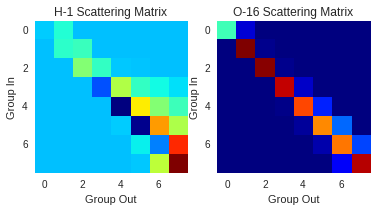

In [33]:
# Create plot of the H-1 scattering matrix
fig = plt.subplot(121)
fig.imshow(h1, interpolation='nearest', cmap='jet')
plt.title('H-1 Scattering Matrix')
plt.xlabel('Group Out')
plt.ylabel('Group In')
plt.grid()

# Create plot of the O-16 scattering matrix
fig2 = plt.subplot(122)
fig2.imshow(o16, interpolation='nearest', cmap='jet')
plt.title('O-16 Scattering Matrix')
plt.xlabel('Group Out')
plt.ylabel('Group In')
plt.grid()

# Show the plot on screen
plt.show()